
# 💎 Diamantanalys för Guldfynd

## Bakgrund
Guldfynd är ett företag specialiserat på smycken av guld och silver. Företaget överväger att utöka sitt sortiment till att även omfatta diamanter. Som dataanalytiker på IT-avdelningen har du fått i uppdrag att analysera ett tillgängligt diamant-dataset för att identifiera insikter som kan vägleda verksamhetens investeringsbeslut.

Syftet:
- Identifiera faktorer som påverkar diamantpriser.
- Förstå fördelningen av olika diamantkvaliteter.
- Skapa en grund för rekommendationer kring sortimentsstrategi.


## Innehållsförteckning
- Bakgrund
- Syftet
- Innehållsförteckning
- Datapreparation

-- Analysen --
- ❓ Biblotek + Code Cleaning
- 🔍 Gruppering
- 🔍 Visualiseringar

Visualiseringar visar:
1. Pris vs Vikt (Carat)
2. Pris per Färg
3. Pris per Klarhet
4. Pris per Slipkvalitet (Cut)
5. Fördelning: Cut
6. Fördelning: Clarity

- 📈 Prisfördelning (Pris x Antal) + (Antal Carat)
- 📊 Sammanfattande Insikter
- 📌 Executive Summary ( Förslag till Guldfynds ledning: )


## Datapreparation
Vi börjar med att ladda in datan, undersöka dess struktur och rensa bort saknade värden för att möjliggöra en pålitlig analys.

## ❓ Biblotek + Code Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## Data Loading and Initial Cleaning
# Load data and handle missing values
df = pd.read_excel('diamonds.xlsx')
df_clean = df.dropna().copy()

print(f"Original dataset: {len(df)} rows")
print(f"After removing NaN: {len(df_clean)} rows")
print(f"Columns: {list(df_clean.columns)}")

## Data Quality Cleaning
# Define columns to validate
physical_cols = ['carat', 'price', 'x', 'y', 'z']
existing_cols = [col for col in physical_cols if col in df_clean.columns]

# Track removal statistics
removal_log = {}

def log_removal(description: str, before_count: int, after_count: int) -> None:
    """Helper function to log data removal."""
    removed = before_count - after_count
    removal_log[description] = removed
    print(f"{description}: {removed} rows removed")

# Remove zero values in physical measurements
if existing_cols:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[existing_cols] != 0).all(axis=1)]
    log_removal("Zero values in physical measurements", before, len(df_clean))

# Clean depth measurements (remove >1% deviation)
if all(col in df_clean.columns for col in ['x', 'y', 'z', 'depth']):
    before = len(df_clean)
    
    # Calculate expected depth percentage
    avg_diameter = (df_clean['x'] + df_clean['y']) / 2
    df_clean['depth_calc'] = (df_clean['z'] / avg_diameter) * 100
    df_clean['depth_diff'] = abs(df_clean['depth_calc'] - df_clean['depth'])
    
    # Filter out diamonds with >1% depth deviation
    df_clean = df_clean[df_clean['depth_diff'] <= 1]
    log_removal(">1% depth deviation", before, len(df_clean))
    
    # Clean up temporary columns
    df_clean = df_clean.drop(['depth_calc', 'depth_diff'], axis=1)

# Clean length-width ratio (remove extreme ratios)
if all(col in df_clean.columns for col in ['x', 'y']):
    before = len(df_clean)
    
    # Calculate length-width ratio
    df_clean['lw_ratio'] = df_clean['x'] / df_clean['y']
    
    # Keep only diamonds with reasonable proportions (0.9-1.1 ratio)
    df_clean = df_clean[
        (df_clean['lw_ratio'] >= 0.9) & 
        (df_clean['lw_ratio'] <= 1.1)
    ]
    log_removal("Length/width ratio outside 0.9-1.1", before, len(df_clean))
    
    # Clean up temporary column
    df_clean = df_clean.drop('lw_ratio', axis=1)

## Cleaning Summary
initial_count = len(df)
final_count = len(df_clean)
total_removed = initial_count - final_count

print(f"\n{'='*50}")
print("DATA CLEANING SUMMARY")
print(f"{'='*50}")
print(f"Original rows: {initial_count:,}")
print(f"Final rows: {final_count:,}")
print(f"Total removed: {total_removed:,}")
print(f"Retention rate: {final_count/initial_count:.1%}")

print(f"\nDetailed removal breakdown:")
for reason, count in removal_log.items():
    percentage = (count / initial_count) * 100
    print(f"  • {reason}: {count:,} rows ({percentage:.1f}%)")

# Display first few rows
print(f"\nFirst 5 rows of cleaned data:")
df_clean.head()

Original dataset: 53940 rows
After removing NaN: 53864 rows
Columns: ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
Zero values in physical measurements: 20 rows removed
>1% depth deviation: 80 rows removed
Length/width ratio outside 0.9-1.1: 0 rows removed

DATA CLEANING SUMMARY
Original rows: 53,940
Final rows: 53,764
Total removed: 176
Retention rate: 99.7%

Detailed removal breakdown:
  • Zero values in physical measurements: 20 rows (0.0%)
  • >1% depth deviation: 80 rows (0.1%)
  • Length/width ratio outside 0.9-1.1: 0 rows (0.0%)

First 5 rows of cleaned data:


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
4,5,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336.0,3.94,3.96,2.48


## 🔍 Gruppering

In [2]:
## Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## Data Loading and Initial Cleaning
# Load data and handle missing values
df = pd.read_excel('diamonds.xlsx')
df_clean = df.dropna().copy()

print(f"Original dataset: {len(df)} rows")
print(f"After removing NaN: {len(df_clean)} rows")
print(f"Columns: {list(df_clean.columns)}")

## Data Quality Cleaning
# Define columns to validate
physical_cols = ['carat', 'price', 'x', 'y', 'z']
existing_cols = [col for col in physical_cols if col in df_clean.columns]

# Track removal statistics
removal_log = {}

def log_removal(description: str, before_count: int, after_count: int) -> None:
    """Helper function to log data removal."""
    removed = before_count - after_count
    removal_log[description] = removed
    print(f"{description}: {removed} rows removed")

# Remove zero values in physical measurements
if existing_cols:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[existing_cols] != 0).all(axis=1)]
    log_removal("Zero values in physical measurements", before, len(df_clean))

# Clean depth measurements (remove >1% deviation)
if all(col in df_clean.columns for col in ['x', 'y', 'z', 'depth']):
    before = len(df_clean)
    
    # Calculate expected depth percentage
    avg_diameter = (df_clean['x'] + df_clean['y']) / 2
    df_clean['depth_calc'] = (df_clean['z'] / avg_diameter) * 100
    df_clean['depth_diff'] = abs(df_clean['depth_calc'] - df_clean['depth'])
    
    # Filter out diamonds with >1% depth deviation
    df_clean = df_clean[df_clean['depth_diff'] <= 1]
    log_removal(">1% depth deviation", before, len(df_clean))
    
    # Clean up temporary columns
    df_clean = df_clean.drop(['depth_calc', 'depth_diff'], axis=1)

# Clean length-width ratio (remove extreme ratios)
if all(col in df_clean.columns for col in ['x', 'y']):
    before = len(df_clean)
    
    # Calculate length-width ratio
    df_clean['lw_ratio'] = df_clean['x'] / df_clean['y']
    
    # Keep only diamonds with reasonable proportions (0.9-1.1 ratio)
    df_clean = df_clean[
        (df_clean['lw_ratio'] >= 0.9) & 
        (df_clean['lw_ratio'] <= 1.1)
    ]
    log_removal("Length/width ratio outside 0.9-1.1", before, len(df_clean))
    
    # Clean up temporary column
    df_clean = df_clean.drop('lw_ratio', axis=1)

## Cleaning Summary
initial_count = len(df)
final_count = len(df_clean)
total_removed = initial_count - final_count

print(f"\n{'='*50}")
print("DATA CLEANING SUMMARY")
print(f"{'='*50}")
print(f"Original rows: {initial_count:,}")
print(f"Final rows: {final_count:,}")
print(f"Total removed: {total_removed:,}")
print(f"Retention rate: {final_count/initial_count:.1%}")

print(f"\nDetailed removal breakdown:")
for reason, count in removal_log.items():
    percentage = (count / initial_count) * 100
    print(f"  • {reason}: {count:,} rows ({percentage:.1f}%)")

# Display first few rows
print(f"\nFirst 5 rows of cleaned data:")
df_clean.head()

## Group Analysis - Price by Categories
print("Analyzing price patterns by categorical variables...")

# Calculate average prices by different categories
price_by_color = df_clean.groupby("color")["price"].mean().sort_index()
price_by_clarity = df_clean.groupby("clarity")["price"].mean().sort_index()
price_by_cut = df_clean.groupby("cut")["price"].mean().sort_index()

# Create GIA-style cut mapping for standardization
cut_mapping = {
    "Ideal": "Excellent",
    "Premium": "Very Good",
    "Very Good": "Good", 
    "Good": "Fair",
    "Fair": "Poor"
}
df_clean["cut_gia"] = df_clean["cut"].map(cut_mapping)
price_by_cut_gia = df_clean.groupby("cut_gia")["price"].mean().sort_index()

print("Average prices calculated for:")
print(f"  • Colors: {len(price_by_color)} categories")
print(f"  • Clarity grades: {len(price_by_clarity)} categories") 
print(f"  • Cut grades: {len(price_by_cut)} categories")

## Group Analysis - Numerical Variable Binning
print("\nCreating binned categories for numerical variables...")

# Create tertile bins for continuous variables
depth_bins = pd.qcut(df_clean["depth"], q=3, labels=["Low", "Medium", "High"])
table_bins = pd.qcut(df_clean["table"], q=3, labels=["Low", "Medium", "High"])
carat_bins = pd.qcut(df_clean["carat"], q=3, labels=["Low", "Medium", "High"])

# Count distributions
depth_counts = depth_bins.value_counts().sort_index()
table_counts = table_bins.value_counts().sort_index()
carat_counts = carat_bins.value_counts().sort_index()

# Categorical variable counts
cut_counts = df_clean["cut"].value_counts()
clarity_counts = df_clean["clarity"].value_counts()

print("Binned variable distributions:")
print(f"  • Depth: {dict(depth_counts)}")
print(f"  • Table: {dict(table_counts)}")
print(f"  • Carat: {dict(carat_counts)}")


Original dataset: 53940 rows
After removing NaN: 53864 rows
Columns: ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
Zero values in physical measurements: 20 rows removed
>1% depth deviation: 80 rows removed
Length/width ratio outside 0.9-1.1: 0 rows removed

DATA CLEANING SUMMARY
Original rows: 53,940
Final rows: 53,764
Total removed: 176
Retention rate: 99.7%

Detailed removal breakdown:
  • Zero values in physical measurements: 20 rows (0.0%)
  • >1% depth deviation: 80 rows (0.1%)
  • Length/width ratio outside 0.9-1.1: 0 rows (0.0%)

First 5 rows of cleaned data:
Analyzing price patterns by categorical variables...
Average prices calculated for:
  • Colors: 7 categories
  • Clarity grades: 8 categories
  • Cut grades: 5 categories

Creating binned categories for numerical variables...
Binned variable distributions:
  • Depth: {'Low': np.int64(19367), 'Medium': np.int64(18013), 'High': np.int64(16384)}
  • Table: {'Low': np.int64(19837),

## 🔎 Visualiseringar

Creating main visualization dashboard...


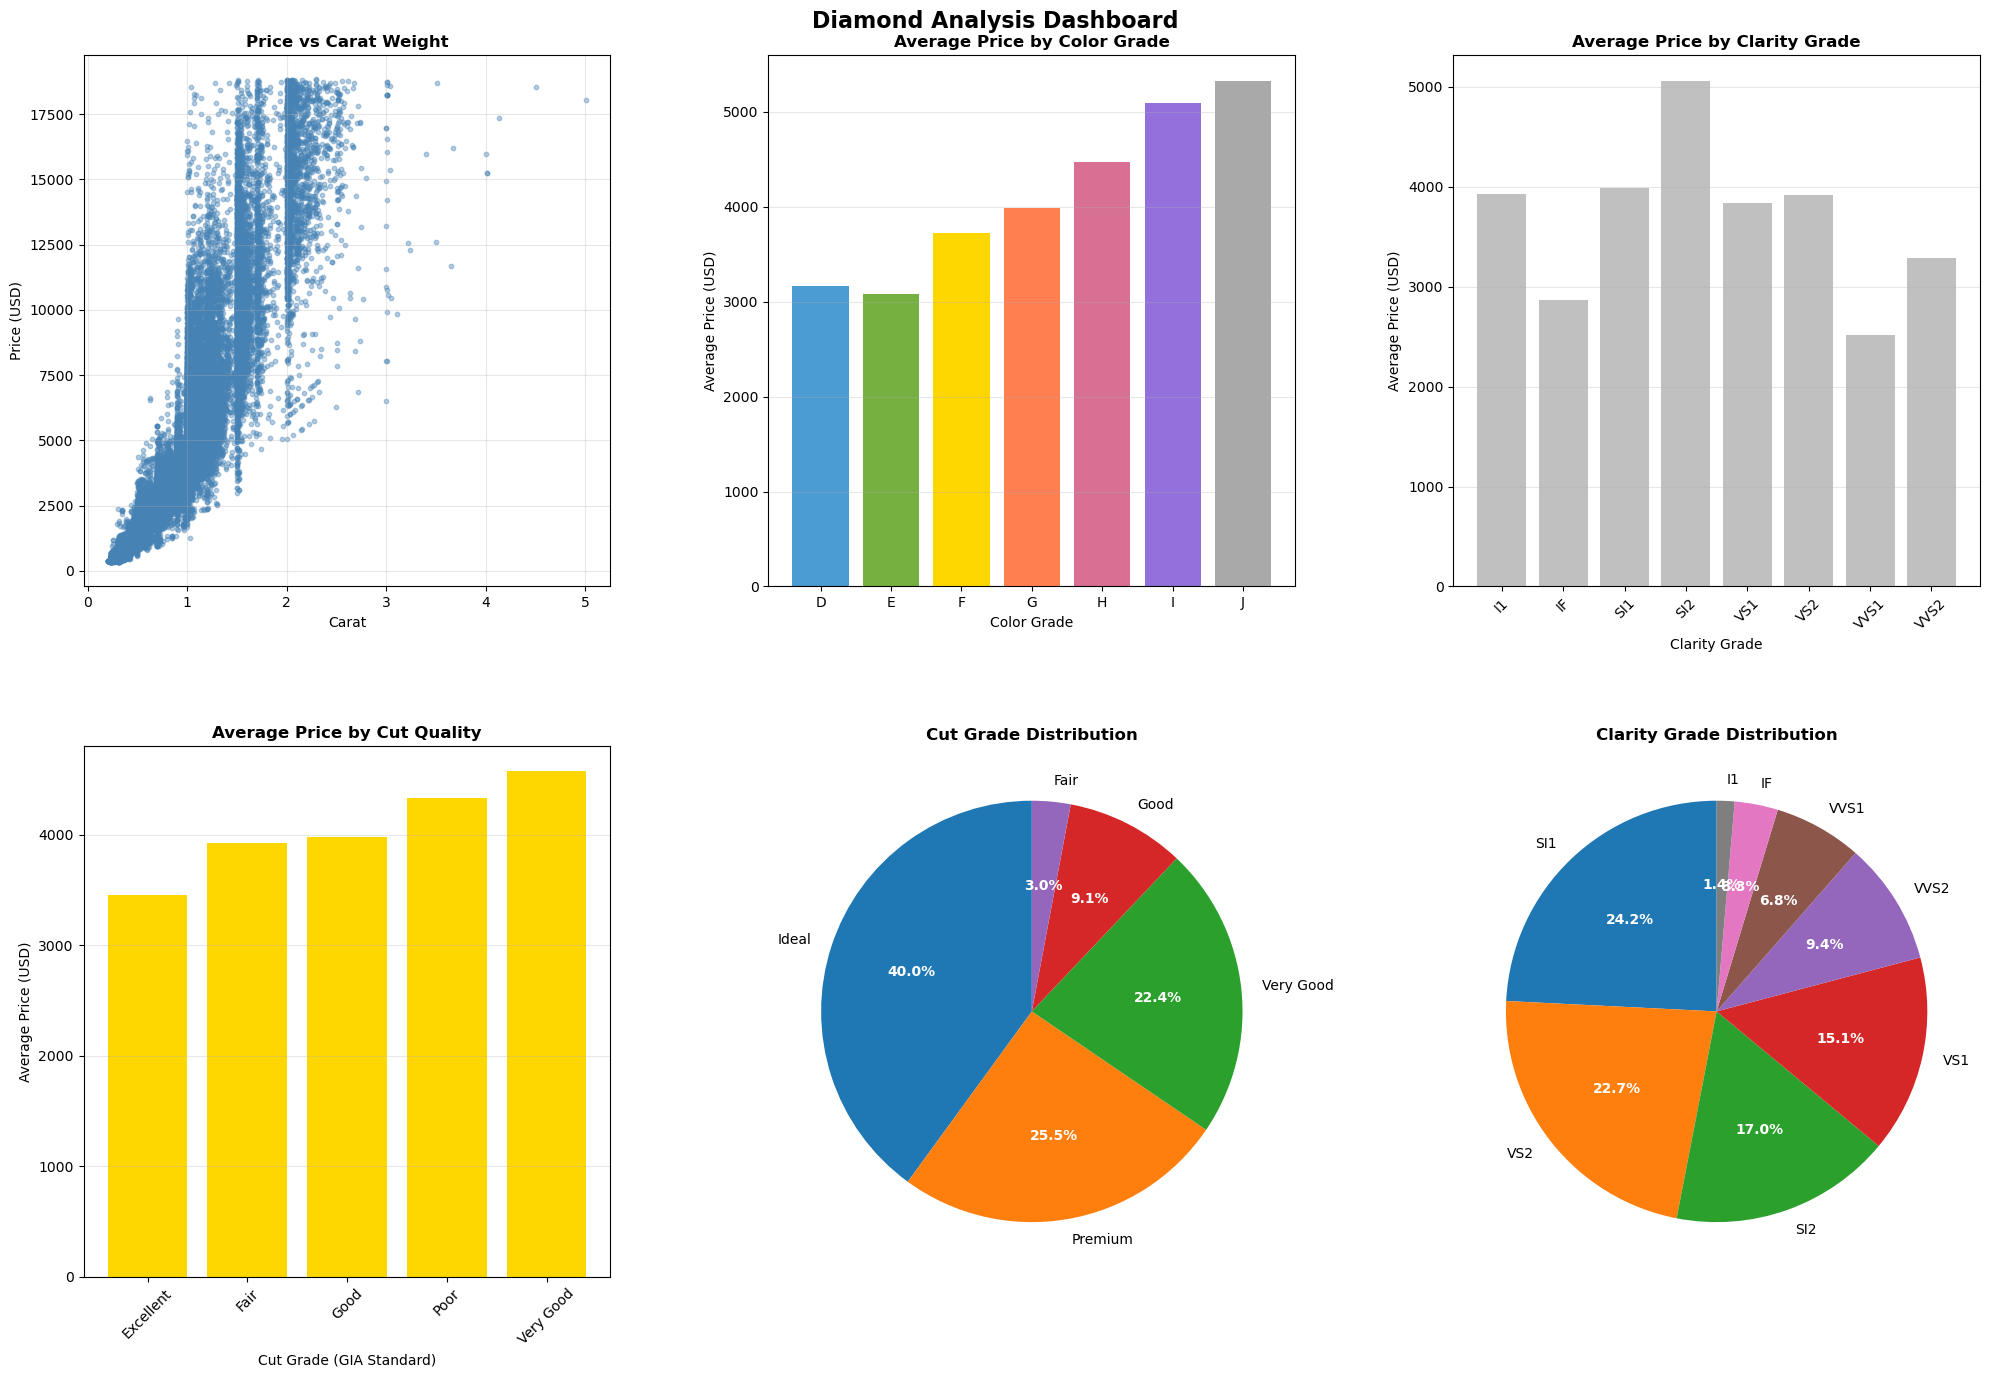

Analyzing price distribution...


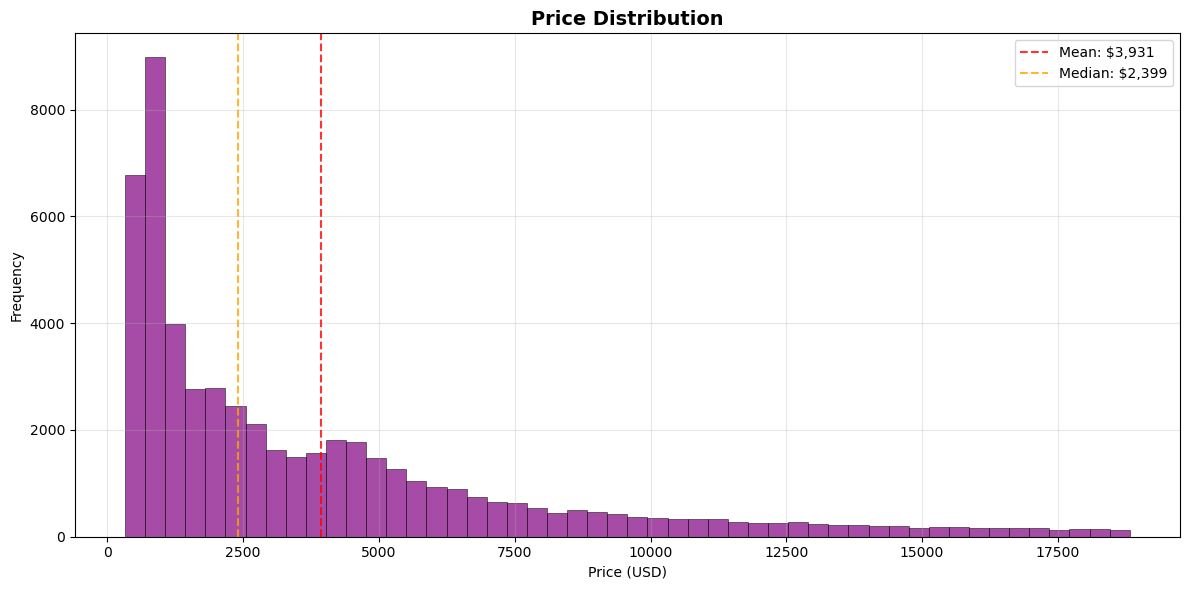

Price statistics:
  • Mean: $3,931
  • Median: $2,399
  • Min: $326
  • Max: $18,823


In [3]:
print("Creating main visualization dashboard...")

# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Diamond Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

# 1. Price vs Carat scatter plot
axes[0, 0].scatter(df_clean["carat"], df_clean["price"], alpha=0.4, color='steelblue', s=10)
axes[0, 0].set_title("Price vs Carat Weight", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Carat")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].grid(True, alpha=0.3)

# 2. Average price by color
color_palette = {
    'D': '#4B9CD3', 'E': '#76B041', 'F': '#FFD700', 'G': '#FF7F50',
    'H': '#D87093', 'I': '#9370DB', 'J': '#A9A9A9'
}
bar_colors = [color_palette.get(color, 'gray') for color in price_by_color.index]

axes[0, 1].bar(price_by_color.index, price_by_color.values, color=bar_colors)
axes[0, 1].set_title("Average Price by Color Grade", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Color Grade")
axes[0, 1].set_ylabel("Average Price (USD)")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Average price by clarity
axes[0, 2].bar(price_by_clarity.index, price_by_clarity.values, color="silver")
axes[0, 2].set_title("Average Price by Clarity Grade", fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel("Clarity Grade")
axes[0, 2].set_ylabel("Average Price (USD)")
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Average price by cut (GIA standardized)
axes[1, 0].bar(price_by_cut_gia.index, price_by_cut_gia.values, color="gold")
axes[1, 0].set_title("Average Price by Cut Quality", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Cut Grade (GIA Standard)")
axes[1, 0].set_ylabel("Average Price (USD)")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Cut distribution pie chart
wedges, texts, autotexts = axes[1, 1].pie(cut_counts.values, labels=cut_counts.index, 
                                         autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Cut Grade Distribution", fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 6. Clarity distribution pie chart  
wedges, texts, autotexts = axes[1, 2].pie(clarity_counts.values, labels=clarity_counts.index,
                                         autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Clarity Grade Distribution", fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

## Distribution Analysis - Price
print("Analyzing price distribution...")

plt.figure(figsize=(12, 6))
plt.hist(df_clean["price"], bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title("Price Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Add summary statistics to the plot
price_mean = df_clean["price"].mean()
price_median = df_clean["price"].median()
plt.axvline(price_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: ${price_mean:,.0f}')
plt.axvline(price_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: ${price_median:,.0f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Price statistics:")
print(f"  • Mean: ${price_mean:,.0f}")
print(f"  • Median: ${price_median:,.0f}")
print(f"  • Min: ${df_clean['price'].min():,.0f}")
print(f"  • Max: ${df_clean['price'].max():,.0f}")


## 📈 Prisfördelning (Pris x Antal) + (Antal Carat)

Analyzing carat weight distribution...


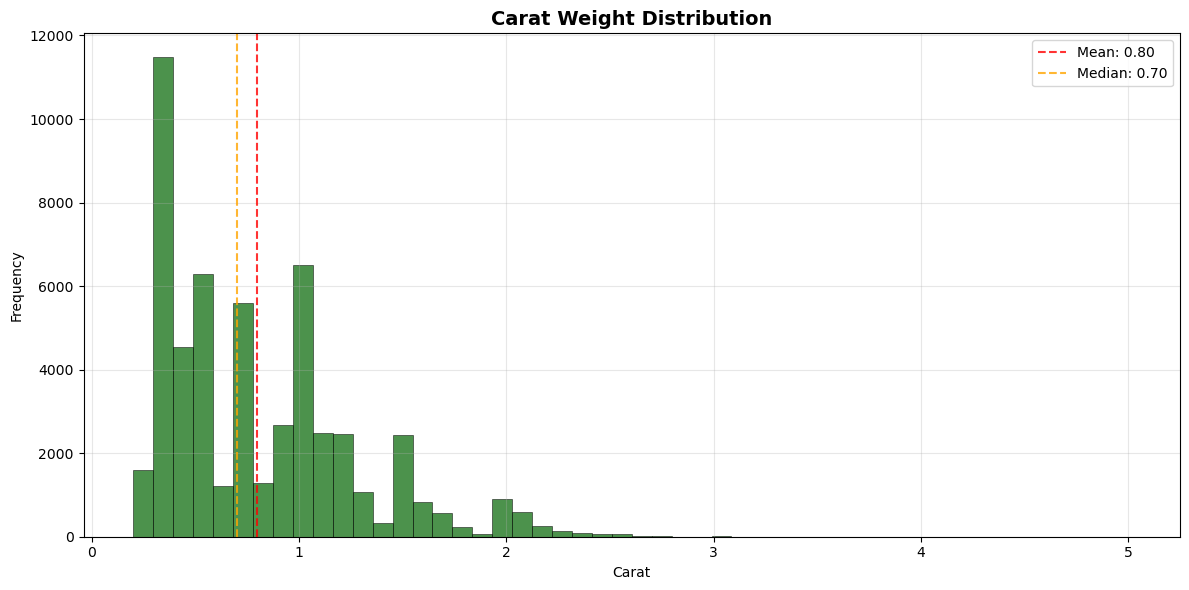

Carat statistics:
  • Mean: 0.80
  • Median: 0.70
  • Min: 0.20
  • Max: 5.01

Final dataset summary:
Shape: (53764, 12)
Memory usage: 14.6 MB

Summary statistics for numerical variables:


In [4]:
print("Analyzing carat weight distribution...")

plt.figure(figsize=(12, 6))
plt.hist(df_clean["carat"], bins=50, color='darkgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title("Carat Weight Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Carat")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Add summary statistics
carat_mean = df_clean["carat"].mean()  
carat_median = df_clean["carat"].median()
plt.axvline(carat_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: {carat_mean:.2f}')
plt.axvline(carat_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: {carat_median:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Carat statistics:")
print(f"  • Mean: {carat_mean:.2f}")
print(f"  • Median: {carat_median:.2f}")
print(f"  • Min: {df_clean['carat'].min():.2f}")
print(f"  • Max: {df_clean['carat'].max():.2f}")

## Summary Statistics
print("\nFinal dataset summary:")
print(f"Shape: {df_clean.shape}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display summary statistics for numerical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
summary_stats = df_clean[numeric_cols].describe()
print(f"\nSummary statistics for numerical variables:")

## 📊 Sammanfattande insikter

Efter att ha analyserat diamantdatasetet framträder följande centrala observationer:

1. **Carat har starkast koppling till priset**  
   Ju högre carat, desto högre pris – med ett tydligt icke-linjärt samband. Det finns ett särskilt prishopp runt 1.0 carat och uppåt.

2. **Slipkvalitet ("cut") har stor påverkan på priset**  
   Diamanter med högre slipkvalitet (t.ex. "Excellent", "Very Good") tenderar att ha högre pris än motsvarande stenar med sämre slip, även vid samma vikt.

3. **Färg och klarhet påverkar – men mer nyanserat**  
   Bättre färg (närmare D) och hög klarhet (t.ex. IF, VVS1) ger generellt högre priser, men variationen inom kategorierna är betydande.

4. **Större delen av diamanterna ligger i ett "mittsegment"**  
   De flesta diamanter har:
   - Vikt mellan **0.9–1.6 carat**
   - Mellannivåer för bord och djup
   - Medelhög klarhet och färg  
   Detta kan spegla både utbud och efterfrågan på marknaden.

5. **Prisspridning inom kategorier tyder på fler dolda faktorer**  
   Betydande variationer i pris finns även inom samma färg, klarhet eller vikt – vilket indikerar att exempelvis certifiering, fluorescens eller marknadsläge också spelar in.

(För dig som inte vet vad fluorescens är.. 
(AI Förklaring: Fluorescens i diamanter syftar på diamantens förmåga att avge ett synligt ljus (ofta blått) när den utsätts för UV-ljus.))


## 📌 Executive Summary

**Insikter:**
- Prisnivån på diamanter ökar kraftigt med ökad carat-vikt, vilket tyder på att vikt är en avgörande faktor för värdet.
- Slipkvalitet ("cut"), färg och klarhet påverkar priset i varierande grad. Särskilt slipkvaliteten har stark korrelation med prisnivåer.
- Majoriteten av diamanterna i datasetet ligger inom viktspannet 0.7–1.2 carat, vilket indikerar var efterfrågan är som störst på marknaden.
- Fördelningen av djup (depth) och bord (table) ligger också i ett tydligt mellansegment, vilket antyder industristandarder för proportioner.
- Betydande prisskillnader förekommer även inom samma kategori (t.ex. färg eller klarhet), vilket antyder att andra faktorer som certifiering, symmetri eller marknadsläge också påverkar priset.

**Rekommendationer:**
- Fokusera på diamanter mellan 0.7 – 1.2 carat, där marginalerna verkar vara bäst.
- Clarity VS2–SI1 och color G–H ger bäst balans mellan pris och kvalitet.
- "Excellent" och "Very Good" cut rekommenderas då de ofta erbjuder hög kvalitet till rimligt pris.
- "Very Good" cut ger ibland högt pris utan proportionellt högre värde.
- Undvik mycket stora diamanter (>2 carat) i första skedet – dessa är få och dyra.

Denna analys ger ett datadrivet underlag för produkturval, sortimentstrategi och prissättning vid en eventuell expansion till diamantförsäljning.